<a href="https://colab.research.google.com/github/laviniaflorentina/neural_networks_dissertation/blob/master/experiment4_all_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Downloads

In [0]:
import os.path
from IPython.display import clear_output

if not os.path.exists("data/train_minist.npz"):
  !wget https://github.com/laviniaflorentina/neural_networks_dissertation/raw/master/data/train_minist.npz
  clear_output(wait=True)

if not os.path.exists("validation_minist.npz"):
  !wget https://github.com/laviniaflorentina/neural_networks_dissertation/raw/master/data/validation_minist.npz
  clear_output(wait=True)

if not os.path.exists("test_minist.npz"):
  !wget https://github.com/laviniaflorentina/neural_networks_dissertation/raw/master/data/test_minist.npz
  clear_output(wait=True)

!ls

sample_data  test_minist.npz  train_minist.npz	validation_minist.npz


### Imports

In [0]:
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels
import pandas as pd
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator



def plot_train(train_history, train=True, validation=True, acc_name='Model accuracy', loss_name='Model loss'):
  legend = []
  
  fig, ax = plt.subplots()
  
  fig.tight_layout()
  fig = plt.gcf()
  fig.set_size_inches(18.5, 10.5)
  #fig.savefig(acc_name+".png", dpi=100)
  
  # summarize history for accuracy
  if train:
    plt.plot(train_history.history['acc'])
    legend.append('train')
    
  if validation:
    plt.plot(train_history.history['val_acc'])
    legend.append('validation')
    
  plt.grid()
  plt.title(acc_name)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')
  plt.xticks((np.arange(len(train_history.history["acc"]))), 
             (np.arange(len(train_history.history["acc"]))+1))
  plt.show()
  
  fig.tight_layout()
  fig = plt.gcf()
  fig.set_size_inches(18.5, 10.5)
  #fig.savefig(loss_name+".png", dpi=100)
  
  legend = []
  
  # summarize history for loss
  if train:
    plt.plot(train_history.history['loss'])
    legend.append('train')
    
  if validation:
    plt.plot(train_history.history['val_loss'])
    legend.append('validation')
    
  plt.grid()
  plt.title(loss_name)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')
  plt.xticks((np.arange(len(train_history.history["acc"]))), 
             (np.arange(len(train_history.history["acc"]))+1))
  plt.show()
  
  return



def global_evaluation(true_labels, predicted_labels, avg='macro'):
  f1 = f1_score(true_labels, predicted_labels, average=avg)
  precision = precision_score(true_labels, predicted_labels, average=avg)
  recall = recall_score(true_labels, predicted_labels, average=avg)
  accuracy = accuracy_score(true_labels, predicted_labels)
  
  evaluation_table = pd.DataFrame({'Metric':["F1-score", "Precision", "Recall", "Accuracy"], "Value":[f1, precision, recall, accuracy] })
  
  return evaluation_table



def micro_evaluation(true_labels, predicted_labels, labels=list(range(10)), avg=None):
  f1 = f1_score(true_labels, predicted_labels, average=avg)
  precision = precision_score(true_labels, predicted_labels, average=avg)
  recall = recall_score(true_labels, predicted_labels, average=avg)
  evaluation_table = pd.DataFrame({'Labels':labels, "precision":precision, "recall":recall, "f1":f1 })
  
  return evaluation_table




def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                         image="confusion_matrix.png"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    fig.savefig(image, dpi=100)
    return ax

Using TensorFlow backend.


### Load Data

In [0]:
npzfile = np.load("train_minist.npz")
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']

npzfile = np.load("validation_minist.npz")
X_validation = npzfile['arr_0']
y_validation = npzfile['arr_1']

npzfile = np.load("test_minist.npz")
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']

print("Train",X_train.shape)
print("Valid",X_validation.shape)
print("Test ",X_test.shape)

Train (3000, 28, 28)
Valid (3000, 28, 28)
Test  (10000, 28, 28)


### Train-Validation Dictionary

In [0]:
train_dictionary = {index:[] for index in range(10)}
[train_dictionary[label].append(image) for image, label in zip(X_train, y_train)];

validation_dictionary = {index:[] for index in range(10)}
[validation_dictionary[label].append(image) for image, label in zip(X_validation, y_validation)];

In [0]:
sum([len(validation_dictionary[i]) for i in range(10)])

3000

### Double Digit

In [0]:
X_tr_double, y_tr_double = [], []
values = 4

for key in train_dictionary.keys():
  # for each value in key
  for value in train_dictionary[key]:
    # for each key in dictionary
    for tmp_key in train_dictionary.keys():
      for _ in range(values):
        pick = random.randint(0, (len(train_dictionary[tmp_key])-1))
        # concatenate
        large_image = np.concatenate((train_dictionary[tmp_key][pick], value), axis=1)
        large_label = tmp_key * 10 + key
        X_tr_double.append(large_image)
        y_tr_double.append(large_label)
X_tr_double = np.array(X_tr_double)
y_tr_double = np.array(y_tr_double)   

print(X_tr_double.shape)


X_vl_double, y_vl_double = [], []

for key in validation_dictionary.keys():
  # for each value in key
  for value in validation_dictionary[key]:
    # for each key in dictionary
    for tmp_key in validation_dictionary.keys():
      pick = random.randint(0, (len(validation_dictionary[tmp_key])-1))
      # concatenate
      large_image = np.concatenate((validation_dictionary[tmp_key][pick], value), axis=1)
      large_label = tmp_key * 10 + key
      X_vl_double.append(large_image)
      y_vl_double.append(large_label)
X_vl_double = np.array(X_vl_double)
y_vl_double = np.array(y_vl_double)

print(X_vl_double.shape)


X_test_double, y_test_double = [], []

for image, label in zip(X_test, y_test):
  first_image = np.zeros((image.shape[0],image.shape[1]))
  large_image = np.concatenate((first_image, image), axis=1)
  X_test_double.append(large_image)
  y_test_double.append(label)
        
X_test_double = np.array(X_test_double)
y_test_double = np.array(y_test_double)


print(X_test_double.shape)

(120000, 28, 56)
(30000, 28, 56)
(10000, 28, 56)


#### Sample

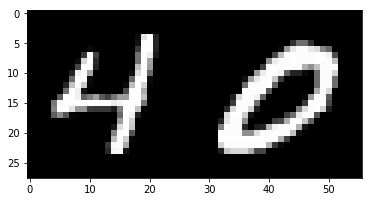

40


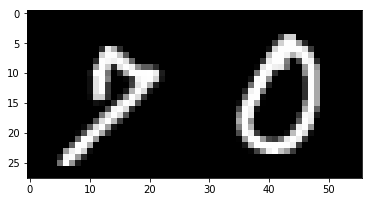

70


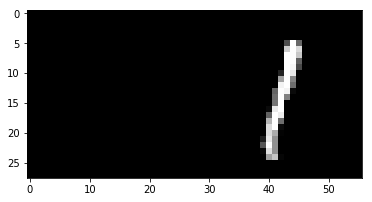

1


In [0]:
i = random.randint(0, 100)
# plot image
plt.imshow(X_tr_double[i], cmap=plt.get_cmap('gray'))
plt.show()
# label
print(y_tr_double[i])

# plot image
plt.imshow(X_vl_double[i], cmap=plt.get_cmap('gray'))
plt.show()
# label
print(y_vl_double[i])

# plot image
plt.imshow(X_test_double[i], cmap=plt.get_cmap('gray'))
plt.show()
# label
print(y_test_double[i])

### Augment Single Digit

In [0]:
rotation = 45
shift = 0.5
noise_range = 0

X_train_scaled = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]).astype('float32')

X_train_noisy = []
y_train_noisy = []

index =0
data_size = 40 * (len(X_train_scaled) - 1)

data_generator = ImageDataGenerator(
                             rotation_range=rotation, 
                             width_shift_range=shift, 
                             height_shift_range=shift, 
                             horizontal_flip=False, 
                             vertical_flip=False)

for batch_image, batch_label in data_generator.flow(X_train_scaled, y_train, batch_size=1):
    
  image = batch_image[0][0]
  label = batch_label[0]
  
  noise_lvl = random.randint(0, noise_range)
  noise = np.random.normal(1,noise_lvl, image.shape)
  
  X_train_noisy.append(image+noise)
  y_train_noisy.append(label)
  
  index +=1
  
  if index % 50000 == 0:
    print(index,data_size)
    
  if index == data_size:
    print("Done!")
    break
    
X_train_noisy = np.array(X_train_noisy)
y_train_noisy = np.array(y_train_noisy)

print(X_train_noisy.shape)


X_validation_scaled = X_validation.reshape(X_validation.shape[0], 1, X_validation.shape[1], X_validation.shape[2]).astype('float32')

X_validation_noisy = []
y_validation_noisy = []

index =0
data_size = len(X_validation_scaled) - 1

data_generator = ImageDataGenerator(
                             rotation_range=rotation, 
                             width_shift_range=shift, 
                             height_shift_range=shift, 
                             horizontal_flip=False, 
                             vertical_flip=False)

for batch_image, batch_label in data_generator.flow(X_validation_scaled, y_validation, batch_size=1):
    
  image = batch_image[0][0]
  label = batch_label[0]
  
  noise_lvl = random.randint(0, noise_range)
  noise = np.random.normal(1,noise_lvl, image.shape)
  
  X_validation_noisy.append(image+noise)
  y_validation_noisy.append(label)
  
  index +=1
  
  if index % 1000 == 0:
    print(index,data_size)
    
  if index == data_size:
    print("Done!")
    break
    
X_validation_noisy = np.array(X_validation_noisy)
y_validation_noisy = np.array(y_validation_noisy)

print(X_validation_noisy.shape)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (3000, 1, 28, 28) (28 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


50000 119960
100000 119960
Done!
(119960, 28, 28)
1000 2999
2000 2999
Done!
(2999, 28, 28)


#### Sample

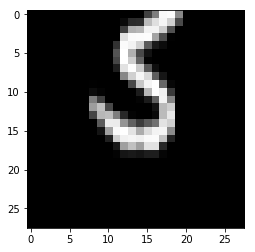

3


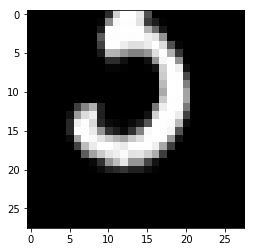

5


In [0]:
i = random.randint(0, 100)
# plot image
plt.imshow(X_train_noisy[i], cmap=plt.get_cmap('gray'))
plt.show()
# label
print(y_train_noisy[i])

# plot image
plt.imshow(X_validation_noisy[i], cmap=plt.get_cmap('gray'))
plt.show()
# label
print(y_validation_noisy[i])

### Baseline CNN

W0905 20:03:20.026602 139783920469888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0905 20:03:20.060503 139783920469888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0905 20:03:20.067377 139783920469888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0905 20:03:20.084157 139783920469888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0905 20:03:20.085920 1397839204

(3000, 28, 28)
(3000, 28, 28)
(10000, 28, 28)


W0905 20:03:23.563098 139783920469888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0905 20:03:23.579376 139783920469888 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0905 20:03:23.632516 139783920469888 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0905 20:03:23.777144 139783920469888 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_suppor

Train on 3000 samples, validate on 3000 samples
Epoch 1/20
3000/3000 [==============================] - 3s 1ms/step - loss: 1.1923 - acc: 0.6913 - val_loss: 0.4961 - val_acc: 0.8603
Epoch 2/20
3000/3000 [==============================] - 0s 75us/step - loss: 0.3947 - acc: 0.8863 - val_loss: 0.3683 - val_acc: 0.8907
Epoch 3/20
3000/3000 [==============================] - 0s 75us/step - loss: 0.2805 - acc: 0.9210 - val_loss: 0.3102 - val_acc: 0.9070
Epoch 4/20
3000/3000 [==============================] - 0s 75us/step - loss: 0.2198 - acc: 0.9367 - val_loss: 0.2858 - val_acc: 0.9190
Epoch 5/20
3000/3000 [==============================] - 0s 75us/step - loss: 0.1809 - acc: 0.9500 - val_loss: 0.2579 - val_acc: 0.9260
Epoch 6/20
3000/3000 [==============================] - 0s 72us/step - loss: 0.1445 - acc: 0.9620 - val_loss: 0.2524 - val_acc: 0.9237
Epoch 7/20
3000/3000 [==============================] - 0s 70us/step - loss: 0.1289 - acc: 0.9680 - val_loss: 0.2275 - val_acc: 0.9347
Epoch 8/

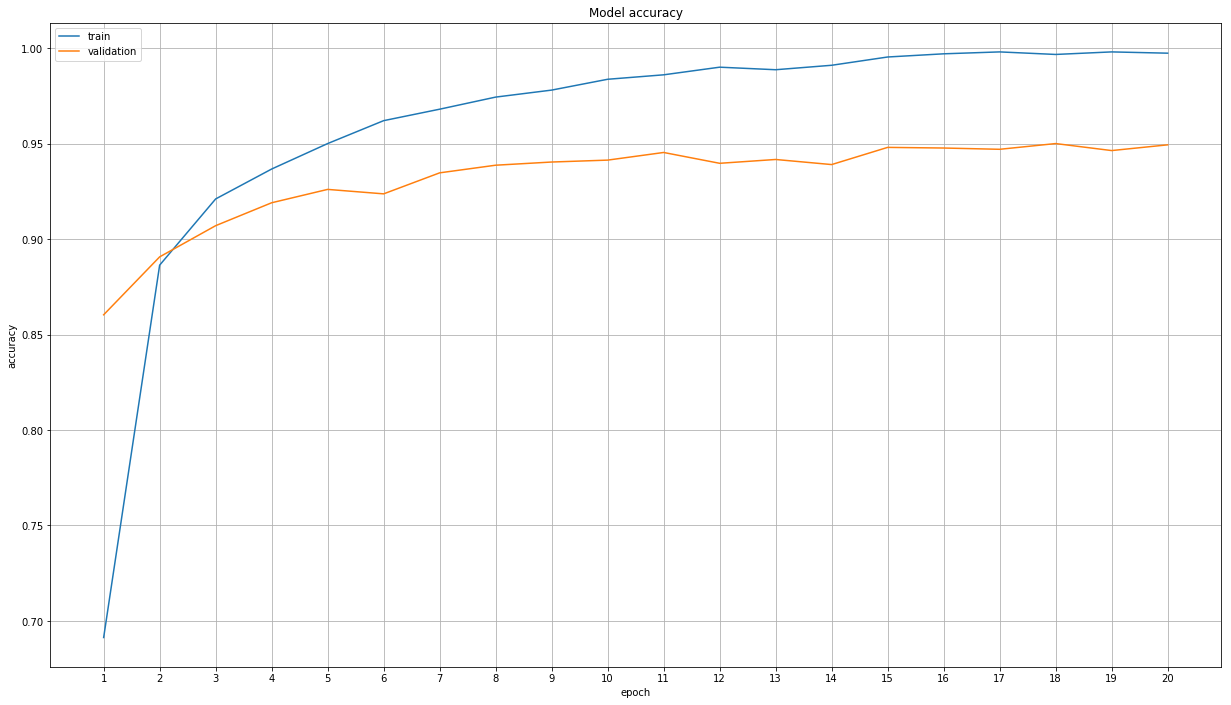

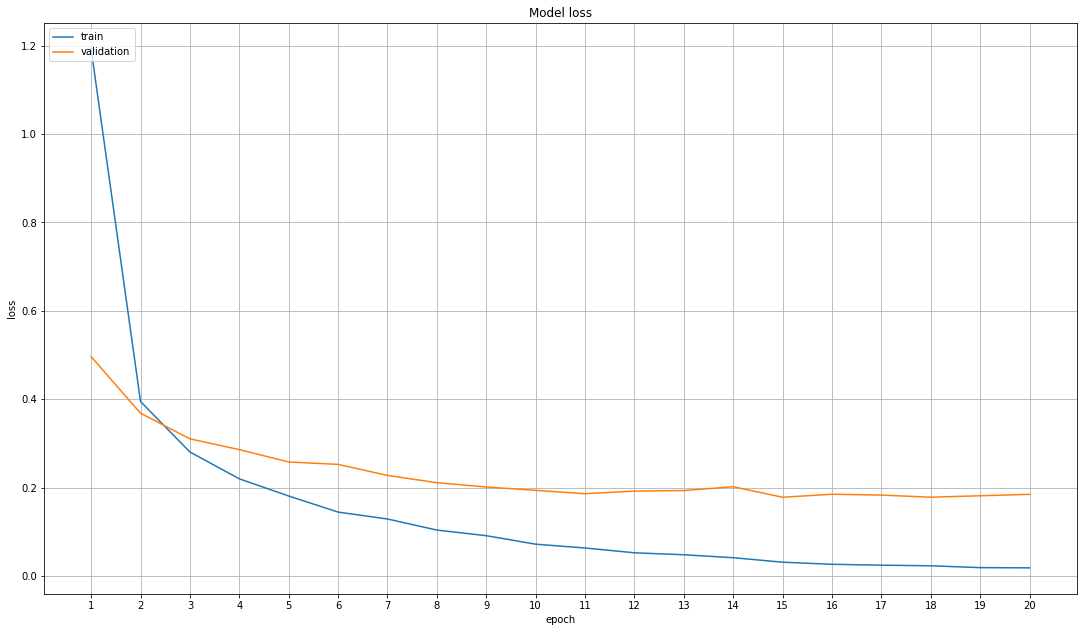

Confusion matrix, without normalization
[[ 959    0    1    0    1    1   13    1    4    0]
 [   0 1124    0    4    1    0    3    2    1    0]
 [   6    7  950   26   12    1    1   19    8    2]
 [   0    0    6  976    1   12    0    7    5    3]
 [   1    2    2    0  961    0    5    1    2    8]
 [   2    1    0    7    0  866    6    3    6    1]
 [   6    2    1    0    8   15  924    2    0    0]
 [   0   11   21    5    8    0    1  968    3   11]
 [   4    3    4   12    8   11    1    3  915   13]
 [   6    7    1    3   16    6    1    9    4  956]]
Normalized confusion matrix
[[9.78571429e-01 0.00000000e+00 1.02040816e-03 0.00000000e+00
  1.02040816e-03 1.02040816e-03 1.32653061e-02 1.02040816e-03
  4.08163265e-03 0.00000000e+00]
 [0.00000000e+00 9.90308370e-01 0.00000000e+00 3.52422907e-03
  8.81057269e-04 0.00000000e+00 2.64317181e-03 1.76211454e-03
  8.81057269e-04 0.00000000e+00]
 [5.81395349e-03 6.78294574e-03 9.20542636e-01 2.51937984e-02
  1.16279070e-02 9.689922

,Metric,Value
0,F1-score,0.959677
1,Precision,0.959800
2,Recall,0.959827
3,Accuracy,0.959900


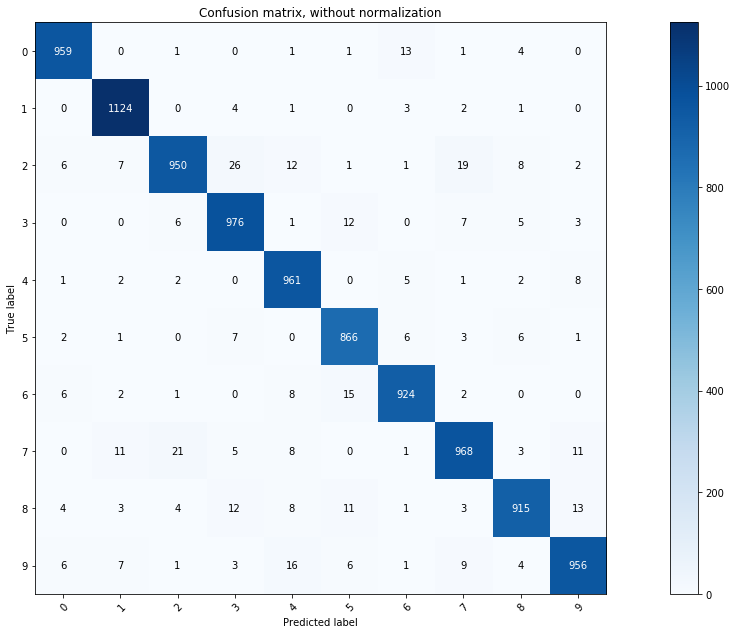

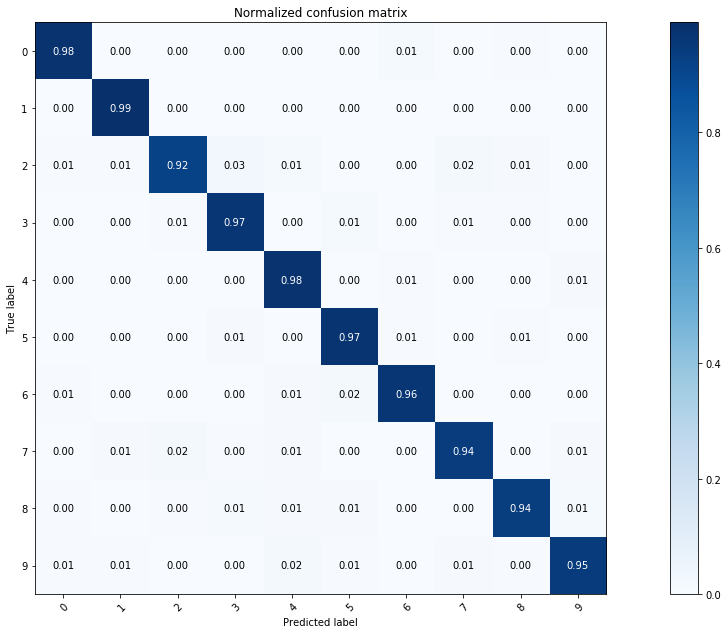

In [0]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
import random
from IPython.display import Image
from keras.utils.vis_utils import plot_model


K.set_image_data_format('channels_first')

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)


def scale_data(images, labels, number_classes=10):
  print(images.shape)
  scaled_images = images.reshape(images.shape[0], 1, images.shape[1], images.shape[2]).astype('float32')
  
  # normalize inputs from 0-255 to 0-1
  # importantfor NN - learn faster
  scaled_images = scaled_images / 255

  # one hot encode outputs
  scaled_labels = np_utils.to_categorical(labels, num_classes=number_classes)
  return scaled_images, scaled_labels


X_train_sc, y_train_sc = scale_data(images=X_train, labels=y_train)
X_valid_sc, y_valid_sc = scale_data(images=X_validation, labels=y_validation)
X_test_sc, _ = scale_data(images=X_test, labels=y_test)

# create model
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=X_train_sc.shape[1:], activation='relu'))      # NOTA !!!! CONVOLUTION
model.add(MaxPooling2D(pool_size=(2, 2)))     # LAYER DE MICSORARE (IA PIXELUL CU VALOARE MAXIMA)
model.add(Dropout(0.2)) #seteaza valori pe zero random din matrici
model.add(Flatten()) # face orice dimensiune intr-un vector
model.add(Dense(128, activation='relu')) # NN normal layer
model.add(Dense(y_train_sc.shape[-1], activation='softmax')) # NN normal layer
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.summary()

history_baseline = model.fit(X_train_sc, y_train_sc, validation_data=(X_valid_sc, y_valid_sc), epochs=20, batch_size=200, verbose=1)

# plot history training
plot_train(train_history=history_baseline, 
           train=True, 
           validation=True)

# predicitons
y_predicted = model.predict_classes(X_test_sc)

plot_confusion_matrix(y_test, y_predicted, classes=np.array(range(10)), normalize=False)

plot_confusion_matrix(y_test, y_predicted, classes=np.array(range(10)), normalize=True)

baseline_cnn_global_evaluation = global_evaluation(y_test, y_predicted)

In [0]:
micro_evaluation(y_test, y_predicted)

,Labels,precision,recall,f1
0,0,0.974593,0.978571,0.976578
1,1,0.971478,0.990308,0.980803
2,2,0.963489,0.920543,0.941526
3,3,0.944821,0.966337,0.955458
4,4,0.945866,0.978615,0.961962
5,5,0.949561,0.970852,0.960089
6,6,0.967539,0.964509,0.966022
7,7,0.953695,0.941634,0.947626
8,8,0.965190,0.939425,0.952133
9,9,0.961771,0.947473,0.954568


### Model CNN Augmented

Train on 119960 samples, validate on 2999 samples
Epoch 1/20
119960/119960 [==============================] - 7s 55us/step - loss: 0.7753 - acc: 0.7513 - val_loss: 0.4320 - val_acc: 0.8576
Epoch 2/20
119960/119960 [==============================] - 6s 50us/step - loss: 0.3083 - acc: 0.8964 - val_loss: 0.3123 - val_acc: 0.9010
Epoch 3/20
119960/119960 [==============================] - 6s 50us/step - loss: 0.2265 - acc: 0.9232 - val_loss: 0.2920 - val_acc: 0.9053
Epoch 4/20
119960/119960 [==============================] - 6s 50us/step - loss: 0.1812 - acc: 0.9385 - val_loss: 0.2801 - val_acc: 0.9110
Epoch 5/20
119960/119960 [==============================] - 6s 50us/step - loss: 0.1521 - acc: 0.9477 - val_loss: 0.2799 - val_acc: 0.9103
Epoch 6/20
119960/119960 [==============================] - 6s 50us/step - loss: 0.1298 - acc: 0.9555 - val_loss: 0.2877 - val_acc: 0.9080
Epoch 7/20
119960/119960 [==============================] - 6s 49us/step - loss: 0.1130 - acc: 0.9613 - val_loss: 0.

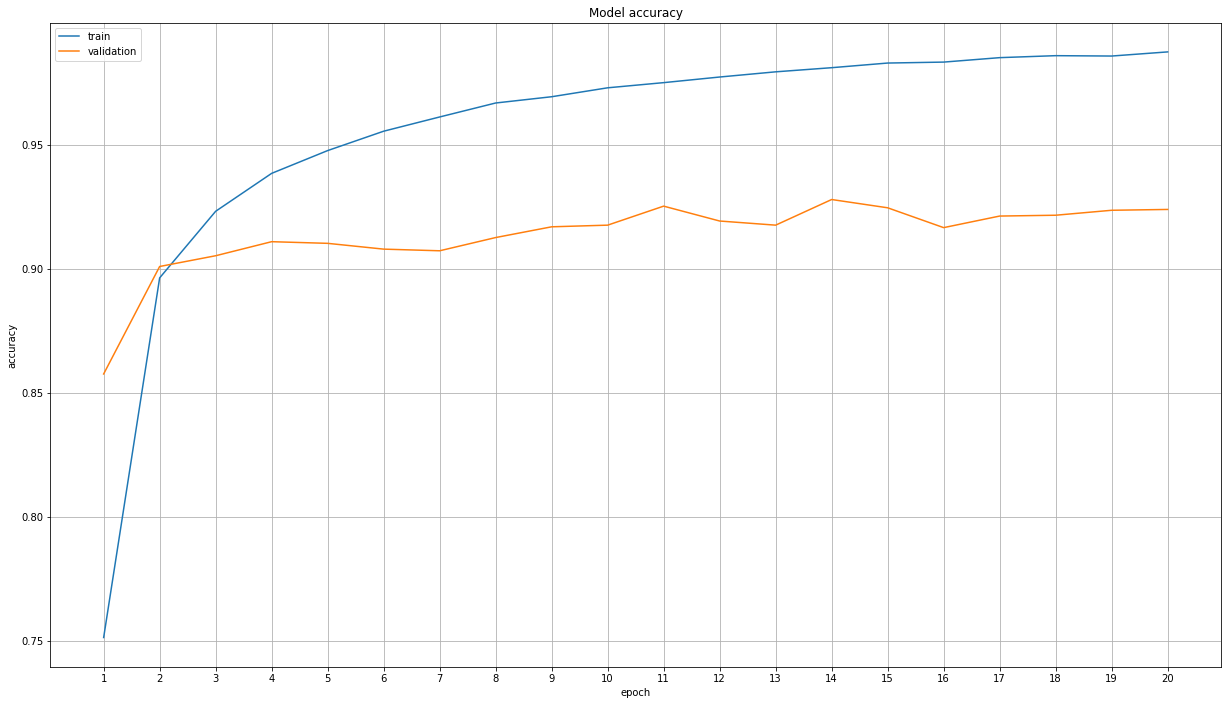

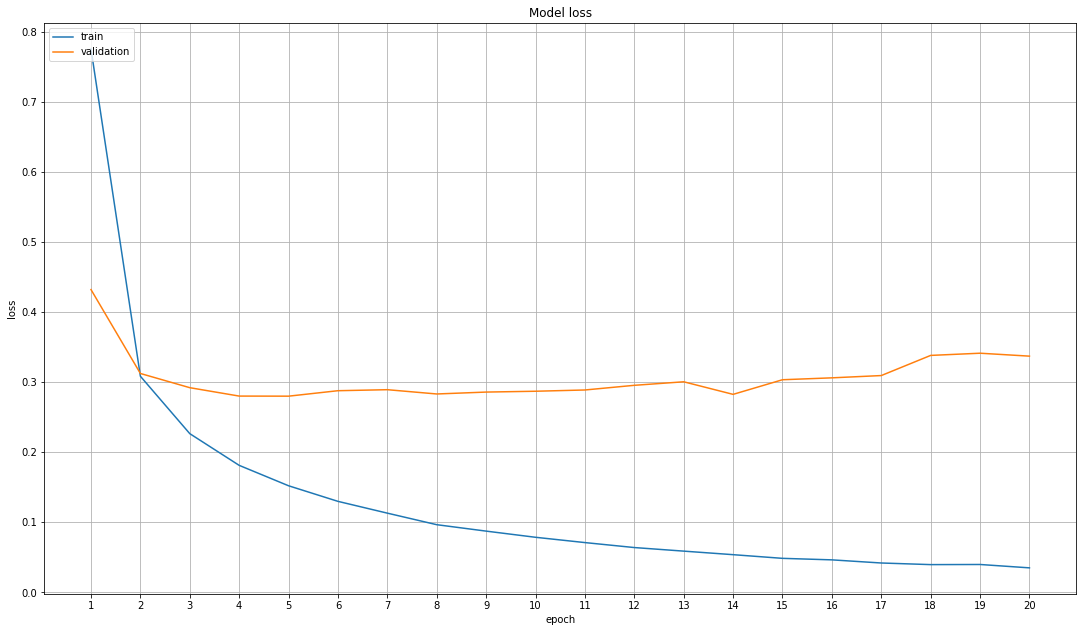

Confusion matrix, without normalization
[[ 949    0    3    0    2    4   10    1    6    5]
 [   0 1106    6    6    7    0    3    5    2    0]
 [   5    0  982   10    3    2    0   15   15    0]
 [   0    0    9  966    0   13    0    7   12    3]
 [   2    1    2    0  943    1    3    4    7   19]
 [   0    0    2    6    0  878    2    1    3    0]
 [   2    1   10    2    5   19  912    0    7    0]
 [   1    4    9    7    3    0    0  989    5   10]
 [   5    0    7    4    2    6    4    6  936    4]
 [   4    4    4    5   11   10    0   19   17  935]]
Normalized confusion matrix
[[9.68367347e-01 0.00000000e+00 3.06122449e-03 0.00000000e+00
  2.04081633e-03 4.08163265e-03 1.02040816e-02 1.02040816e-03
  6.12244898e-03 5.10204082e-03]
 [0.00000000e+00 9.74449339e-01 5.28634361e-03 5.28634361e-03
  6.16740088e-03 0.00000000e+00 2.64317181e-03 4.40528634e-03
  1.76211454e-03 0.00000000e+00]
 [4.84496124e-03 0.00000000e+00 9.51550388e-01 9.68992248e-03
  2.90697674e-03 1.937984

,Metric,Value
0,F1-score,0.959432
1,Precision,0.959437
2,Recall,0.959708
3,Accuracy,0.959600


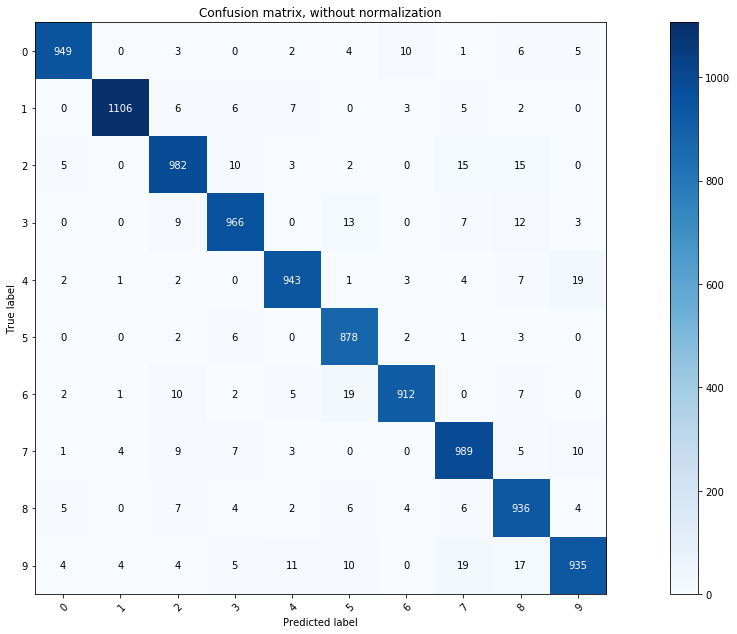

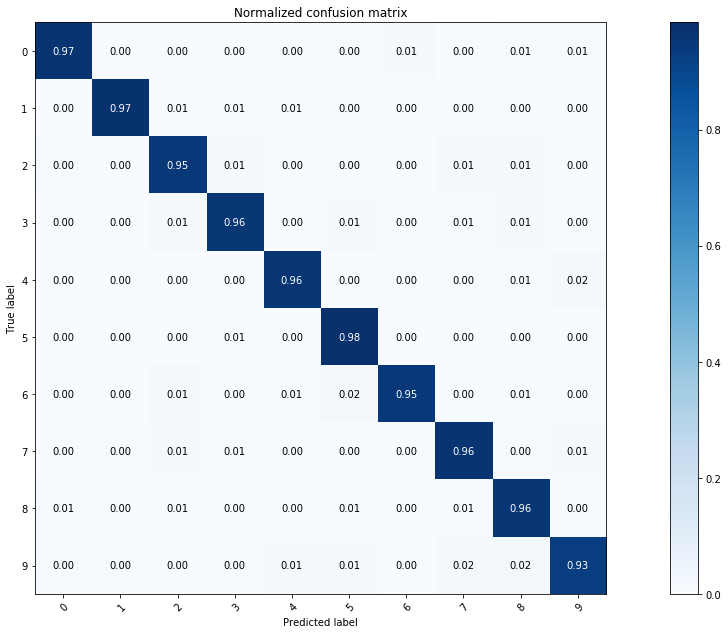

In [0]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
import random
from IPython.display import Image
from keras.utils.vis_utils import plot_model
from sklearn.utils import shuffle


K.set_image_data_format('channels_first')

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)


def scale_data(images, labels, number_classes=100):

#   images, labels = shuffle(images, labels)
  
  scaled_images = images.reshape(images.shape[0], 1, images.shape[1], images.shape[2]).astype('float32')
  
  # normalize inputs from 0-255 to 0-1
  # importantfor NN - learn faster
  scaled_images = scaled_images / 255

  # one hot encode outputs
  scaled_labels = np_utils.to_categorical(labels, num_classes=number_classes)
  return scaled_images, scaled_labels

X_train_sc, y_train_sc = scale_data(images=X_train_noisy, labels=y_train_noisy)
X_valid_sc, y_valid_sc = scale_data(images=X_validation_noisy, labels=y_validation_noisy)
X_test_sc, _ = scale_data(images=X_test, labels=y_test)


# create model
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=X_train_sc.shape[1:], activation='relu'))      # NOTA !!!! CONVOLUTION
model.add(MaxPooling2D(pool_size=(2, 2)))     # LAYER DE MICSORARE (IA PIXELUL CU VALOARE MAXIMA)
model.add(Dropout(0.2)) #seteaza valori pe zero random din matrici
model.add(Flatten()) # face orice dimensiune intr-un vector
model.add(Dense(128, activation='relu')) # NN normal layer
model.add(Dense(y_train_sc.shape[-1], activation='softmax')) # NN normal layer
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



history_augment = model.fit(X_train_sc, y_train_sc, validation_data=(X_valid_sc, y_valid_sc), epochs=20, batch_size=200, verbose=1)

# plot history training
plot_train(train_history=history_augment, 
           train=True, 
           validation=True)

# predicitons
y_predicted = model.predict_classes(X_test_sc)
y_predicted = np.array([number%10 for number in y_predicted])

plot_confusion_matrix(y_test, y_predicted, classes=np.array(range(10)), normalize=False)

plot_confusion_matrix(y_test, y_predicted, classes=np.array(range(10)), normalize=True)


global_evaluation(y_test, y_predicted)

In [0]:
micro_evaluation(y_test, y_predicted)

,Labels,precision,recall,f1
0,0,0.980372,0.968367,0.974333
1,1,0.991039,0.974449,0.982674
2,2,0.949710,0.951550,0.950629
3,3,0.960239,0.956436,0.958333
4,4,0.966189,0.960285,0.963228
5,5,0.941050,0.984305,0.962192
6,6,0.976445,0.951983,0.964059
7,7,0.944604,0.962062,0.953253
8,8,0.926733,0.960986,0.943548
9,9,0.957992,0.926660,0.942065


### Model CNN

Train on 120000 samples, validate on 30000 samples
Epoch 1/20
120000/120000 [==============================] - 10s 82us/step - loss: 0.7305 - acc: 0.8001 - val_loss: 0.4019 - val_acc: 0.8797
Epoch 2/20
120000/120000 [==============================] - 9s 78us/step - loss: 0.0936 - acc: 0.9735 - val_loss: 0.3708 - val_acc: 0.9001
Epoch 3/20
120000/120000 [==============================] - 9s 78us/step - loss: 0.0309 - acc: 0.9922 - val_loss: 0.3651 - val_acc: 0.9114
Epoch 4/20
120000/120000 [==============================] - 9s 78us/step - loss: 0.0154 - acc: 0.9962 - val_loss: 0.4261 - val_acc: 0.9069
Epoch 5/20
120000/120000 [==============================] - 9s 77us/step - loss: 0.0135 - acc: 0.9962 - val_loss: 0.4415 - val_acc: 0.9109
Epoch 6/20
120000/120000 [==============================] - 9s 77us/step - loss: 0.0110 - acc: 0.9968 - val_loss: 0.4110 - val_acc: 0.9182
Epoch 7/20
120000/120000 [==============================] - 9s 78us/step - loss: 0.0080 - acc: 0.9977 - val_loss: 

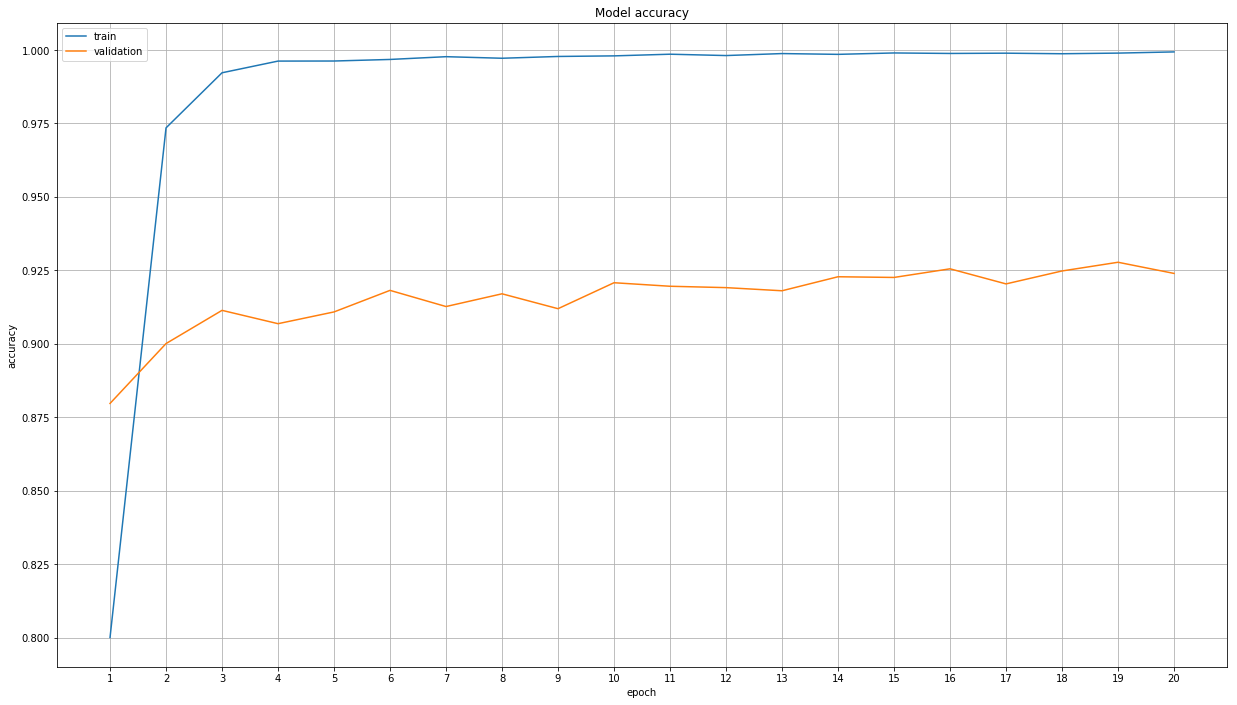

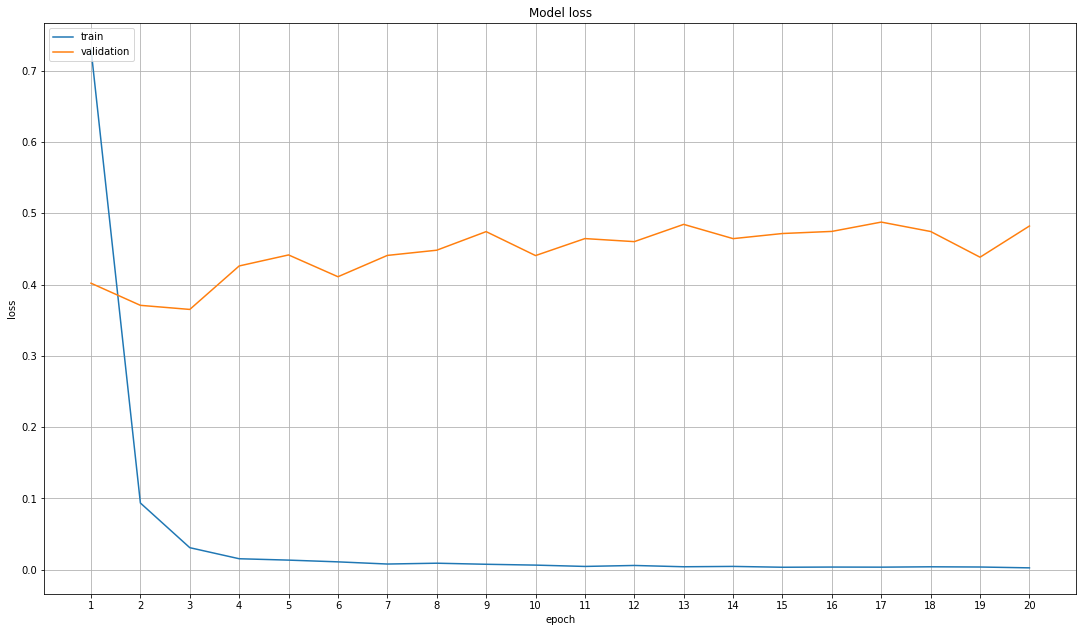

Confusion matrix, without normalization
[[ 963    0    0    0    2    1    3    2    9    0]
 [   0 1085    0   11    2    0    2    5   30    0]
 [   0    0  979    9    6    0    1   20   17    0]
 [   0    0    2  989    0    3    0    6    9    1]
 [   0    0    1    1  957    0    6    0    4   13]
 [   2    0    0   22    1  841    3    2   19    2]
 [   2    1    0    0    8    6  932    0    9    0]
 [   0    0   11    7    2    1    0  992   10    5]
 [   2    0    1    1    2    0    1    2  960    5]
 [   3    0    1    1    9    4    0    8   11  972]]
Normalized confusion matrix
[[9.82653061e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.04081633e-03 1.02040816e-03 3.06122449e-03 2.04081633e-03
  9.18367347e-03 0.00000000e+00]
 [0.00000000e+00 9.55947137e-01 0.00000000e+00 9.69162996e-03
  1.76211454e-03 0.00000000e+00 1.76211454e-03 4.40528634e-03
  2.64317181e-02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.48643411e-01 8.72093023e-03
  5.81395349e-03 0.000000

,Metric,Value
0,F1-score,0.967043
1,Precision,0.967812
2,Recall,0.967062
3,Accuracy,0.967000


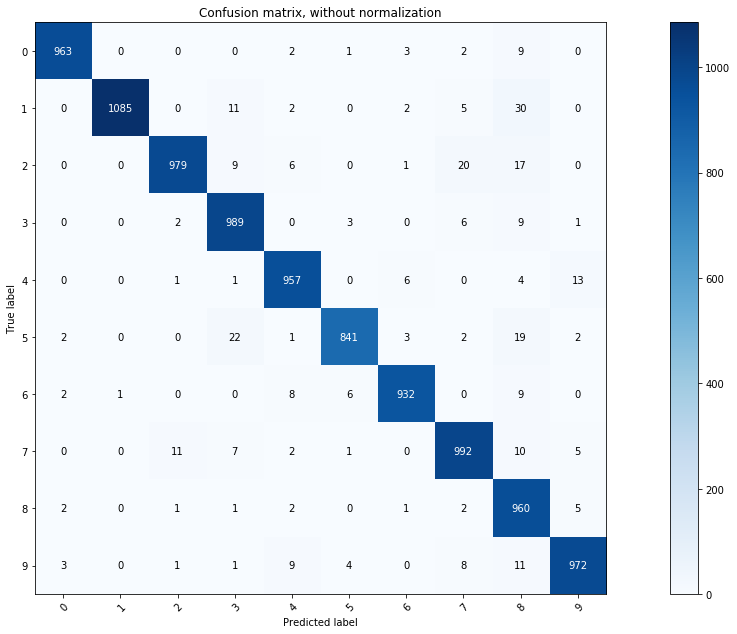

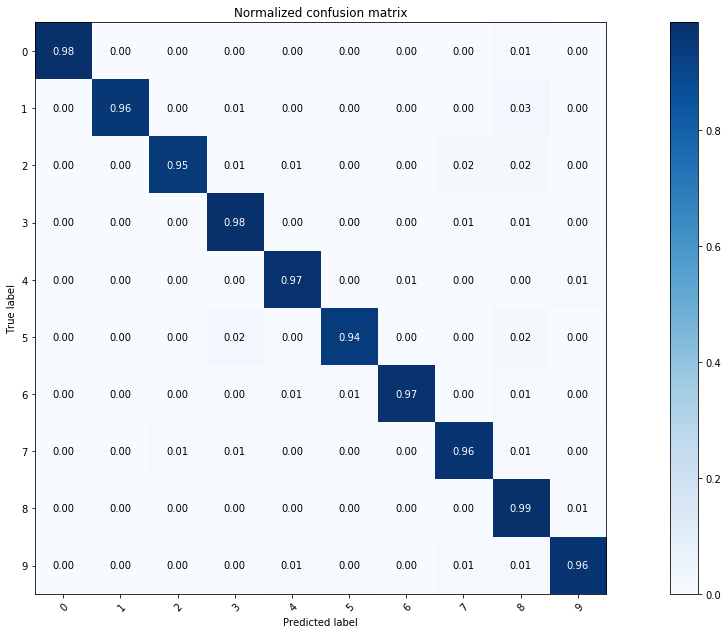

In [0]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
import random
from IPython.display import Image
from keras.utils.vis_utils import plot_model
from sklearn.utils import shuffle


K.set_image_data_format('channels_first')

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)


def scale_data(images, labels, number_classes=100):

#   images, labels = shuffle(images, labels)
  
  scaled_images = images.reshape(images.shape[0], 1, images.shape[1], images.shape[2]).astype('float32')
  
  # normalize inputs from 0-255 to 0-1
  # importantfor NN - learn faster
  scaled_images = scaled_images / 255

  # one hot encode outputs
  scaled_labels = np_utils.to_categorical(labels, num_classes=number_classes)
  return scaled_images, scaled_labels

X_train_sc, y_train_sc = scale_data(images=X_tr_double, labels=y_tr_double)
X_valid_sc, y_valid_sc = scale_data(images=X_vl_double, labels=y_vl_double)
X_test_sc, _ = scale_data(images=X_test_double, labels=y_test_double)


# create model
model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape=X_train_sc.shape[1:], activation='relu'))      # NOTA !!!! CONVOLUTION
model.add(MaxPooling2D(pool_size=(2, 2)))     # LAYER DE MICSORARE (IA PIXELUL CU VALOARE MAXIMA)
model.add(Dropout(0.2)) #seteaza valori pe zero random din matrici
model.add(Flatten()) # face orice dimensiune intr-un vector
model.add(Dense(128, activation='relu')) # NN normal layer
model.add(Dense(y_train_sc.shape[-1], activation='softmax')) # NN normal layer
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



history_model = model.fit(X_train_sc, y_train_sc, validation_data=(X_valid_sc, y_valid_sc), epochs=20, batch_size=200, verbose=1)

# plot history training
plot_train(train_history=history_model, 
           train=True, 
           validation=True)

# predicitons
y_predicted = model.predict_classes(X_test_sc)
y_predicted = np.array([number%10 for number in y_predicted])

plot_confusion_matrix(y_test_double, y_predicted, classes=np.array(range(10)), normalize=False)

plot_confusion_matrix(y_test_double, y_predicted, classes=np.array(range(10)), normalize=True)


global_evaluation(y_test_double, y_predicted)

In [0]:
micro_evaluation(y_test_double, y_predicted)

,Labels,precision,recall,f1
0,0,0.990741,0.982653,0.986680
1,1,0.999079,0.955947,0.977037
2,2,0.983920,0.948643,0.965960
3,3,0.950048,0.979208,0.964408
4,4,0.967644,0.974542,0.971081
5,5,0.982477,0.942825,0.962243
6,6,0.983122,0.972860,0.977964
7,7,0.956606,0.964981,0.960775
8,8,0.890538,0.985626,0.935673
9,9,0.973948,0.963330,0.968610


### Model diagram

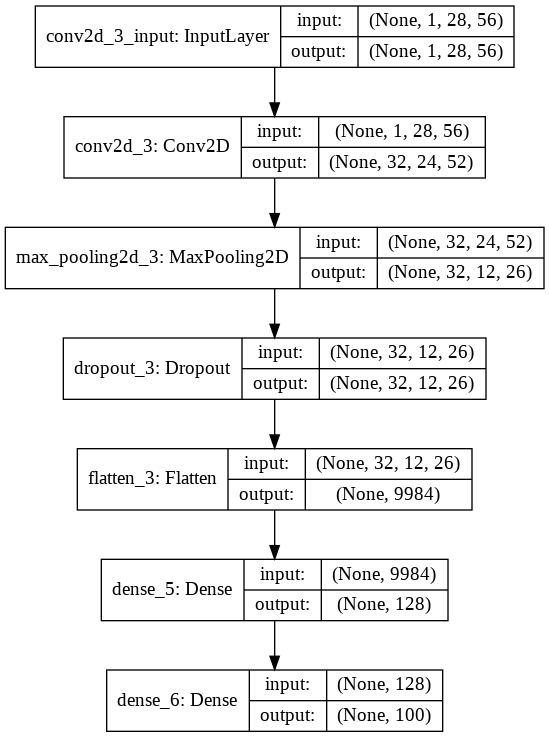

In [0]:
# image model
plot_model(model, to_file='model_layers.png', show_shapes=True, show_layer_names=True)
Image('model_layers.png')

### Plot Histories

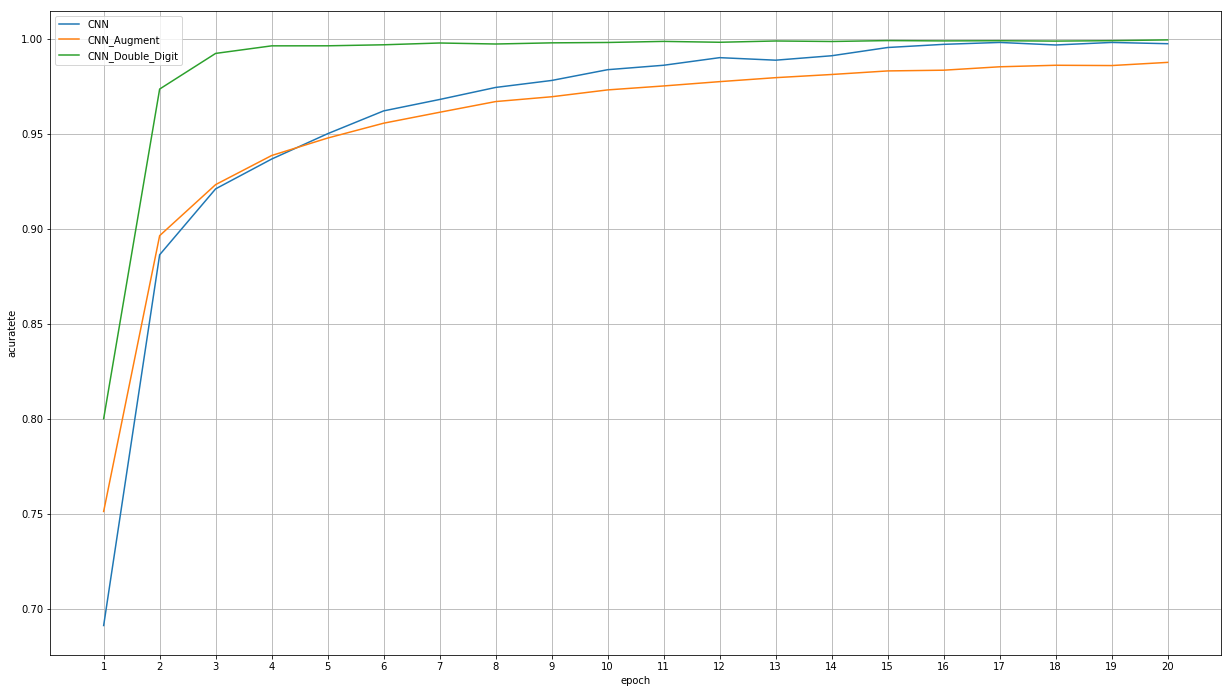

In [0]:
legend = []

fig, ax = plt.subplots()

fig.tight_layout()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.plot(history_baseline.history["acc"])
legend.append('CNN')

plt.plot(history_augment.history["acc"])
legend.append('CNN_Augment')

plt.plot(history_model.history["acc"])
legend.append('CNN_Double_Digit')

plt.grid()
# plt.title()
plt.ylabel('acuratete')
plt.xlabel('epoch')
plt.legend(legend, loc='upper left')
plt.xticks((np.arange(len(history_baseline.history["acc"]))), 
           (np.arange(len(history_baseline.history["acc"]))+1))
plt.show()


fig.savefig("ex4_all_models_accuracy.png", dpi=100)

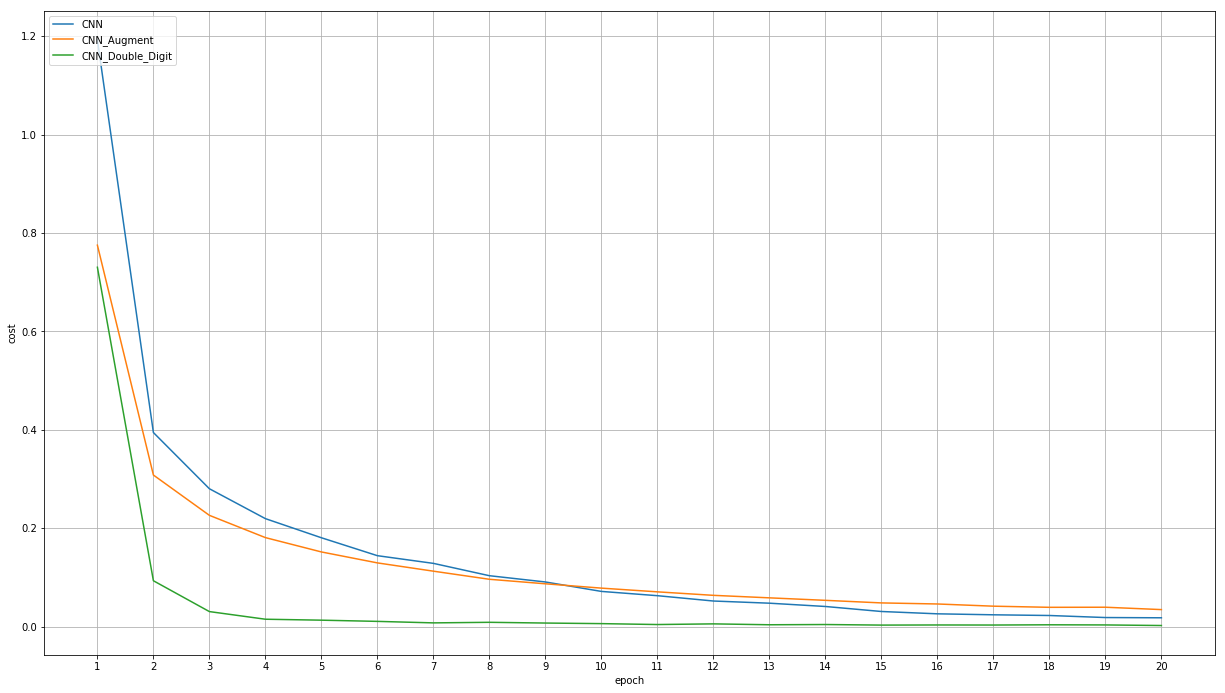

In [0]:
legend = []

fig, ax = plt.subplots()

fig.tight_layout()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

plt.plot(history_baseline.history["loss"])
legend.append('CNN')

plt.plot(history_augment.history["loss"])
legend.append('CNN_Augment')

plt.plot(history_model.history["loss"])
legend.append('CNN_Double_Digit')

plt.grid()
# plt.title()
plt.ylabel('cost')
plt.xlabel('epoch')
plt.legend(legend, loc='upper left')
plt.xticks((np.arange(len(history_baseline.history["loss"]))), 
           (np.arange(len(history_baseline.history["loss"]))+1))
plt.show()


fig.savefig("ex4_all_models_loss.png", dpi=100)